# Data Wrangling

## Gene Expression

The Allen Brain Institute's 'Mouse Whole Cortex and Hippocampus SMART-seq (2019)' dataset collected single-cell transcriptomes from about 77,000 cells across multiple cortical areas and the hippocampus of transgenic adult mice tissue samples. From this broad dataset, another subset of data called 'A transcriptomic taxonomy of adult mouse anterior lateral motor cortex (ALM)' found on the Single Cell Portal--a webapge that facilitates public access to scientific results--narrowed in on samples solely recorded in the anterior lateral motor cortex, condensing the sample size to 1,301 cells. This dataset was downloaded directly into a local device, then uploaded into our group's shared repository for streamlined access and manipulation in JupyterNotebook. We are interested in the clusters.txt file that details the cell sample identifiers, cell cluster grouping, and refined sub-cluster grouping assignments. From past research papers that also harnessed this scRNA-seq data from the Allen Brain Institute (Tasic et al., 2018), the cluster groupings were initially determined by whether they were GABAergic, glutamatergic, or non-neuronal (endothelial cells, glia, etc.). We also imported the expression.txt file that contains RPKM-normalized gene expression values across 45,764 genes for each single-cell sample. RPKM (reads per kilobase per million mapped reads) corrects for both sequencing depth per sample and gene length, enabling meaningful comparisons between samples instead of analyzing just raw read counts.

In [1]:
# Importing essential pipelines and packages from downstream data manipulation and analysis
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.cluster import KMeans
import scanpy as sc

In [2]:
# Loading in the clusters.txt and expression.txt files into corresponding dataframes
clusters_data = pd.read_csv('clusters.txt', delimiter='\t',index_col=None) # The original file is tab-separated
clusters_data = clusters_data.drop(index=0).reset_index(drop=True) # Removing the first row that does not contain any sample information

# Checking the structure of each dataframe
clusters_data.head()

,NAME,CLUSTER,SUB-CLUSTER
0,LS-15012_S01_E1-50,Sst,Sst Myh8_4
1,LS-15012_S02_E1-50,Sst,Sst Mrap2_3
2,LS-15012_S03_E1-50,Sst,Sst Myh8_4
3,LS-15012_S04_E1-50,Sst,Sst Mrap2_2
4,LS-15012_S05_E1-50,Sst,Sst Myh8_4


In [3]:
expression_data = pd.read_csv('expression.txt') 
expression_data.set_index('GENE', inplace=True)
print(expression_data.shape)
expression_data.head()

(45764, 1301)


,LS-15012_S95_E1-50,LS-15012_S94_E1-50,LS-15012_S93_E1-50,LS-15012_S92_E1-50,LS-15012_S91_E1-50,LS-15012_S90_E1-50,LS-15012_S89_E1-50,LS-15012_S80_E1-50,LS-15012_S79_E1-50,LS-15012_S78_E1-50,...,LS-15346_S11_E1-50,LS-15346_S10_E1-50,LS-15346_S09_E1-50,LS-15346_S08_E1-50,LS-15346_S07_E1-50,LS-15346_S06_E1-50,LS-15346_S04_E1-50,LS-15346_S03_E1-50,LS-15346_S02_E1-50,LS-15346_S01_E1-50
GENE,,,,,,,,,,,,,,,,,,,,,
Pzp,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.00,...,0.0,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.0
Aanat,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.00,...,0.0,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.0
Aatk,30.88,0.0,0.00,6.97,0.0,0.55,26.26,0.0,0.52,5.66,...,0.0,7.06,11.65,5.8,0.00,0.58,0.13,0.00,1.66,0.0
Abca1,0.00,0.0,0.71,14.07,0.0,0.00,0.00,0.0,2.90,7.26,...,0.0,0.00,0.00,0.0,4.35,0.00,0.00,20.51,0.00,0.0
Abca4,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.00,...,0.0,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.0


# Data Visualization

### PCA and K-Means Clustering Based on Gene Expression
Based on the shape of the expression data, we can confirm there are 45,764 genes stored as individual rows, and 1,301 ALM cell samples stored in columns. Before analyzing specific gene markers present in the ALM, we want to first identify  similarities or differences between the cells based on their transcriptomic profiles. Principal Component Analysis (PCA), an unsupervised dimensionality reduction technique, can narrow down our high-dimensional gene expression data (in our case, over 45,000 genes for 1,301 cells) to a few principal components that best explain the variance between samples to reveal underlying patterns in cell classes. After PCA, we will apply unsupervised k-means clustering to determine if there are innate groupings of cell clusters (GABAergic vs. glutamatergic vs. non-neuronal) that are dependent on their transcriptomic patterns. We will merge our clustering results with the clusters metadata file to validate that the unbiased k-means labelings are reflective of the true biological heterogeneity, indicated by color-coding. 

In [4]:
# Step 1: Transposing the dataframe to now have samples (observations) as rows, genes (variables) as columns
expression_data_new = expression_data.T
print(expression_data_new.shape) # Should be 1,301 rows and 45,764 columns)
expression_data_new.head()

(1301, 45764)


GENE,Pzp,Aanat,Aatk,Abca1,Abca4,Abca2,Abcb7,Abcg1,Abi1,Abl1,...,LOC105247280,LOC105247281,LOC105247282,LOC105247283,LOC105247284,LOC105247285,LOC105247286,LOC105247287,LOC105247288,LOC105247289
LS-15012_S95_E1-50,0.0,0.0,30.88,0.00,0.0,2.15,0.00,0.00,0.00,0.00,...,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00
LS-15012_S94_E1-50,0.0,0.0,0.00,0.00,0.0,3.58,0.00,0.00,0.00,0.00,...,0.0,0.0,0.0,0.0,2.92,0.0,0.0,0.0,0.0,0.00
LS-15012_S93_E1-50,0.0,0.0,0.00,0.71,0.0,11.75,0.00,0.00,8.46,0.13,...,0.0,0.0,0.0,0.0,0.00,29.6,0.0,0.0,0.0,0.00
LS-15012_S92_E1-50,0.0,0.0,6.97,14.07,0.0,7.19,23.72,1.31,43.48,0.00,...,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,31.24
LS-15012_S91_E1-50,0.0,0.0,0.00,0.00,0.0,8.89,0.27,0.00,2.06,0.00,...,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,27.25


In [5]:
# Step 2.1: Log2-transforming each value to reduce skewedness
expression_data_log = np.log2(expression_data_new + 1) 
print(expression_data_log.shape)  # Should still be 1,301 rows and 45,764 columns

# Step 2.2: Normaling each gene column of the dataset individually; each gene could have a wide spread of expression values dependent on cell type, but standardizing it centers the mean to 0 and STD to 1
scaler = StandardScaler()
expression_data_norm = scaler.fit_transform(expression_data_log)
expression_data_norm = pd.DataFrame(expression_data_norm, index=expression_data_new.index, columns=expression_data_new.columns) # Transforming the standardized data back into a DataFrame
expression_data_norm.head()

(1301, 45764)


GENE,Pzp,Aanat,Aatk,Abca1,Abca4,Abca2,Abcb7,Abcg1,Abi1,Abl1,...,LOC105247280,LOC105247281,LOC105247282,LOC105247283,LOC105247284,LOC105247285,LOC105247286,LOC105247287,LOC105247288,LOC105247289
LS-15012_S95_E1-50,-0.141705,-0.108131,2.011370,-0.385914,-0.081764,-0.114286,-0.946481,-1.312018,-2.247084,-0.578677,...,0.0,-0.047324,0.0,0.0,-0.500412,-0.079373,0.0,0.0,-0.027735,-0.495178
LS-15012_S94_E1-50,-0.141705,-0.108131,-1.301409,-0.385914,-0.081764,0.281554,-0.946481,-1.312018,-2.247084,-0.578677,...,0.0,-0.047324,0.0,0.0,1.073527,-0.079373,0.0,0.0,-0.027735,-0.495178
LS-15012_S93_E1-50,-0.141705,-0.108131,-1.301409,0.388319,-0.081764,1.364315,-0.946481,-1.312018,-0.556663,-0.423726,...,0.0,-0.047324,0.0,0.0,-0.500412,19.313917,0.0,0.0,-0.027735,-0.495178
LS-15012_S92_E1-50,-0.141705,-0.108131,0.684820,3.528888,-0.081764,0.896222,2.046539,-0.351714,0.607838,-0.578677,...,0.0,-0.047324,0.0,0.0,-0.500412,-0.079373,0.0,0.0,-0.027735,3.447479
LS-15012_S91_E1-50,-0.141705,-0.108131,-1.301409,-0.385914,-0.081764,1.095688,-0.723455,-1.312018,-1.405726,-0.578677,...,0.0,-0.047324,0.0,0.0,-0.500412,-0.079373,0.0,0.0,-0.027735,3.297508


In [6]:
#Step 3: Performing PCA on our StandardScaler-normalized expression data
pca = PCA()                            
expression_data_PCA = pca.fit_transform(expression_data_norm)    
print(expression_data_PCA)

[[ 1.85127210e+01 -2.69555926e+00 -3.38200264e+01 ...  7.14984089e-01
   7.33240148e-01  8.75025174e-14]
 [ 2.13219335e+01 -1.48575015e+01 -5.17519019e+00 ... -2.09795988e-01
  -3.05561504e-01  8.75025174e-14]
 [ 1.96241501e+01 -3.64895292e+00 -3.15523354e+01 ...  1.13735511e+00
  -4.48171886e-01  8.75025174e-14]
 ...
 [ 9.81100028e+01  1.85599977e+01  9.46689168e+01 ...  1.10131225e-01
   4.64563693e-02  8.75025174e-14]
 [ 1.07038328e+01 -1.30449081e+01 -9.19802326e+00 ... -1.48876275e+00
   7.66593548e-01  8.75025174e-14]
 [ 1.22071894e+02  2.15339446e+01  7.64171372e+01 ...  3.45313593e-02
  -1.60779916e-02  8.75025174e-14]]


In [7]:
# Step 4: Assigning PC1 and PC2 to their own columns in the normalized expression DataFrame
expression_data_norm['PC1'] = expression_data_PCA[:,0]
expression_data_norm['PC2'] = expression_data_PCA[:,1]
expression_data_norm.head()

GENE,Pzp,Aanat,Aatk,Abca1,Abca4,Abca2,Abcb7,Abcg1,Abi1,Abl1,...,LOC105247282,LOC105247283,LOC105247284,LOC105247285,LOC105247286,LOC105247287,LOC105247288,LOC105247289,PC1,PC2
LS-15012_S95_E1-50,-0.141705,-0.108131,2.011370,-0.385914,-0.081764,-0.114286,-0.946481,-1.312018,-2.247084,-0.578677,...,0.0,0.0,-0.500412,-0.079373,0.0,0.0,-0.027735,-0.495178,18.512721,-2.695559
LS-15012_S94_E1-50,-0.141705,-0.108131,-1.301409,-0.385914,-0.081764,0.281554,-0.946481,-1.312018,-2.247084,-0.578677,...,0.0,0.0,1.073527,-0.079373,0.0,0.0,-0.027735,-0.495178,21.321934,-14.857502
LS-15012_S93_E1-50,-0.141705,-0.108131,-1.301409,0.388319,-0.081764,1.364315,-0.946481,-1.312018,-0.556663,-0.423726,...,0.0,0.0,-0.500412,19.313917,0.0,0.0,-0.027735,-0.495178,19.624150,-3.648953
LS-15012_S92_E1-50,-0.141705,-0.108131,0.684820,3.528888,-0.081764,0.896222,2.046539,-0.351714,0.607838,-0.578677,...,0.0,0.0,-0.500412,-0.079373,0.0,0.0,-0.027735,3.447479,12.553666,-7.712350
LS-15012_S91_E1-50,-0.141705,-0.108131,-1.301409,-0.385914,-0.081764,1.095688,-0.723455,-1.312018,-1.405726,-0.578677,...,0.0,0.0,-0.500412,-0.079373,0.0,0.0,-0.027735,3.297508,24.507305,0.425625


In [8]:
# Step 5: Applying a k-means clustering algorithm

#Setting up three potential clusters: GABAergic, glutamatergic, and non-neuronal
kmeans = KMeans(n_clusters=3, random_state = 42)

#Fitting with the two-dimensional PCA data for the first 10 PC components to capture the most meaningful variance
expression_data_PCA_subset = expression_data_PCA[:,:10]
kmeans.fit(expression_data_PCA_subset)

#Adding the kmeans labels as their own column in the normalized expression DataFrame
expression_data_norm['kmeans_group'] = kmeans.labels_

In [9]:
# Step 6.1: Adding a 'NAME' column label in the column that contains all of the sample identifiers for downstream merging
expression_data_norm['NAME'] = expression_data_norm.index 

# Step 6.2: Merging together the clusters information with the normalized expression data based upon mutual sample identifiers
merged_data = pd.merge(clusters_data, expression_data_norm, on='NAME', how='inner')
merged_data.set_index('NAME', inplace=True)
print(merged_data.shape) # Should still have 1,301 samples
merged_data.head()

(1301, 45769)


,CLUSTER,SUB-CLUSTER,Pzp,Aanat,Aatk,Abca1,Abca4,Abca2,Abcb7,Abcg1,...,LOC105247283,LOC105247284,LOC105247285,LOC105247286,LOC105247287,LOC105247288,LOC105247289,PC1,PC2,kmeans_group
NAME,,,,,,,,,,,,,,,,,,,,,
LS-15012_S01_E1-50,Sst,Sst Myh8_4,-0.141705,-0.108131,0.636811,-0.385914,-0.081764,0.248722,-0.387708,-1.312018,...,0.0,-0.500412,-0.079373,0.0,0.0,-0.027735,-0.495178,10.975007,-8.550597,1
LS-15012_S02_E1-50,Sst,Sst Mrap2_3,-0.141705,-0.108131,-0.379744,-0.385914,-0.081764,-0.049185,0.791443,0.300743,...,0.0,0.942956,-0.079373,0.0,0.0,-0.027735,-0.495178,-13.911122,-18.222924,1
LS-15012_S03_E1-50,Sst,Sst Myh8_4,-0.141705,-0.108131,0.432081,-0.385914,-0.081764,0.531305,1.325139,-1.312018,...,0.0,-0.500412,-0.079373,0.0,0.0,-0.027735,-0.495178,-4.854704,-16.011016,1
LS-15012_S04_E1-50,Sst,Sst Mrap2_2,-0.141705,-0.108131,0.193605,-0.385914,-0.081764,-0.864251,-0.946481,-1.112498,...,0.0,-0.500412,-0.079373,0.0,0.0,-0.027735,0.493882,2.768199,-11.730772,1
LS-15012_S05_E1-50,Sst,Sst Myh8_4,-0.141705,-0.108131,1.658158,-0.385914,-0.081764,-0.949469,1.446871,-0.528522,...,0.0,-0.500412,-0.079373,0.0,0.0,-0.027735,-0.495178,-0.359689,-13.166911,1


In [10]:
# Checking the names of each cluster label
print(merged_data['CLUSTER'].unique())

['Sst' 'Sst Chodl' 'Vip ' 'Vip' 'Vip Sncg' 'L6a_Foxp2' 'L2-3' 'Lamp5'
 'L5a' 'L5_Tshz2' 'Pvalb' 'Meis2' 'L4-5' 'Endo' 'Glia' 'SMC' 'L6b']


Each cluster label is specified by a marker gene rather than their broad classification of GABAergic, glutamatergic, or non-neuronal. Fortunately, Bosiljka Tasic and team also analyzed transcriptomic expression in both the primary visual cortex and the anterior lateral motor cortex from Allen Brain Institute RNAseq datasets, publishing their findings in a paper 'Shared and distinct transcriptomic cell types across neocortical areas' in 2018. According to their paper, the broad cell type taxonomies are:
 - Sst, Sst-Chodl, Vip, Vip Sncg, Lamp5, Pvalb, and Meis2 are GABAergic (see Section: GABAergic cell type taxonomy by scRNA-seq)
 - L6a-Foxp2, L2-3, L5a, L5-Tshz2, L4-5, and L6b are glutamatergic (see Section: Glutamatergic taxonomy by scRNA-seq and projections)
 - Endo (endothelial cells), glia, and SMC (smooth muscle cells) are non-neuronal

In [11]:
# Step 7.1: Creating a dictionary for each cluster name based on the 2018 research paper
cluster_celltype = {
    'Sst': 'GABAergic', 
    'Sst Chodl': 'GABAergic', 
    'Vip ': 'GABAergic', 
    'Vip': 'GABAergic', 
    'Vip Sncg': 'GABAergic', 
    'Lamp5': 'GABAergic', 
    'Pvalb': 'GABAergic', 
    'Meis2': 'GABAergic',
    'L6a_Foxp2': 'Glutamatergic', 
    'L2-3': 'Glutamatergic', 
    'L5a': 'Glutamatergic', 
    'L5_Tshz2': 'Glutamatergic', 
    'L4-5': 'Glutamatergic', 
    'L6b': 'Glutamatergic',
    'Endo': 'Non-neuronal', 
    'Glia': 'Non-neuronal', 
    'SMC': 'Non-neuronal'
}

# Step 7.2: Adding a new 'cell_type' column for the three broader cell type classes
merged_data['cell_type'] = merged_data['CLUSTER'].map(cluster_celltype)
merged_data.head()

,CLUSTER,SUB-CLUSTER,Pzp,Aanat,Aatk,Abca1,Abca4,Abca2,Abcb7,Abcg1,...,LOC105247284,LOC105247285,LOC105247286,LOC105247287,LOC105247288,LOC105247289,PC1,PC2,kmeans_group,cell_type
NAME,,,,,,,,,,,,,,,,,,,,,
LS-15012_S01_E1-50,Sst,Sst Myh8_4,-0.141705,-0.108131,0.636811,-0.385914,-0.081764,0.248722,-0.387708,-1.312018,...,-0.500412,-0.079373,0.0,0.0,-0.027735,-0.495178,10.975007,-8.550597,1,GABAergic
LS-15012_S02_E1-50,Sst,Sst Mrap2_3,-0.141705,-0.108131,-0.379744,-0.385914,-0.081764,-0.049185,0.791443,0.300743,...,0.942956,-0.079373,0.0,0.0,-0.027735,-0.495178,-13.911122,-18.222924,1,GABAergic
LS-15012_S03_E1-50,Sst,Sst Myh8_4,-0.141705,-0.108131,0.432081,-0.385914,-0.081764,0.531305,1.325139,-1.312018,...,-0.500412,-0.079373,0.0,0.0,-0.027735,-0.495178,-4.854704,-16.011016,1,GABAergic
LS-15012_S04_E1-50,Sst,Sst Mrap2_2,-0.141705,-0.108131,0.193605,-0.385914,-0.081764,-0.864251,-0.946481,-1.112498,...,-0.500412,-0.079373,0.0,0.0,-0.027735,0.493882,2.768199,-11.730772,1,GABAergic
LS-15012_S05_E1-50,Sst,Sst Myh8_4,-0.141705,-0.108131,1.658158,-0.385914,-0.081764,-0.949469,1.446871,-0.528522,...,-0.500412,-0.079373,0.0,0.0,-0.027735,-0.495178,-0.359689,-13.166911,1,GABAergic


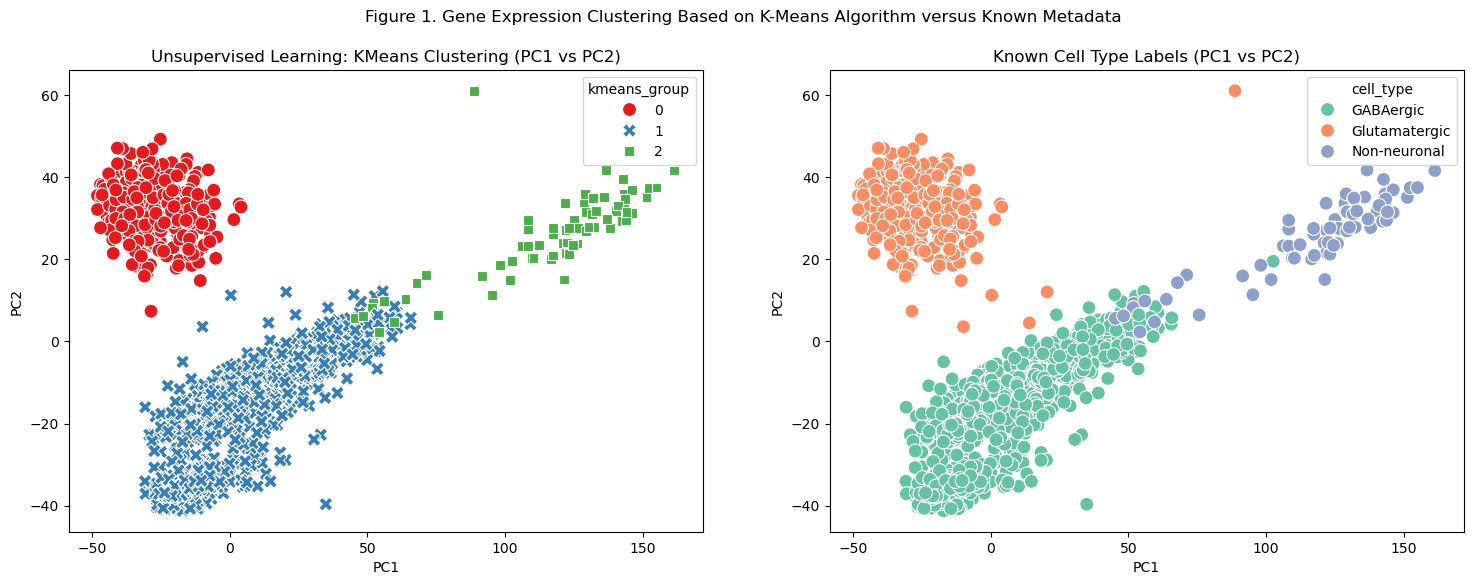

In [12]:
# Step 8: Validating our k-means clustering based on normalized gene expression to known cell type classifications
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Scatter plot of k-means clustering on the left subplot
sns.scatterplot(x='PC1', y='PC2', hue='kmeans_group', data=merged_data, palette='Set1', style='kmeans_group', s=100, ax=axes[0])
axes[0].set_title("Unsupervised Learning: KMeans Clustering (PC1 vs PC2)")

# Scatter plot of known cell types on the right subplot
sns.scatterplot(x='PC1', y='PC2', hue='cell_type', data=merged_data, palette='Set2', s=100, ax=axes[1])
axes[1].set_title("Known Cell Type Labels (PC1 vs PC2)")

fig.suptitle ('Figure 1. Gene Expression Clustering Based on K-Means Algorithm versus Known Metadata')
plt.show()

Figure 1. Side-by-side comparison of unsupervised k-means cluster assignments (fitted by the first 10 PC components) versus known cell type cluster assignments. The k-means plot (left) showcases how samples cluster based on their PC1 and PC2 components, with colors representing each k-means cluster label. This initially-blind algorithm reveals underlying transcriptomic patterns that could suggest three potential cell type groupings (albeit defined a priori by us). The known cell type plot (right) also displays how samples cluster based on their PC1 and PC2 components, but with colors solely corresponding to their known cell type classifications extracted from the clusters metadata file. 

Based on these subplots, we can infer that unsupervised k-means clustering based on normalized gene expression data  captures differences in cellular compositions/functions, as the k-means labels and known cell type labels have a similar overlap and alignment. In the data analysis section, we will harness statistical measures like the Adjusted Rand Index to compare how similar our k-means versus known cell clustering methods are.

### Heatmap of ALM-specific Gene Expression
Now that we have identified broad sub-populations of cell types within our ALM-specific RNAseq dataset, we want to further investigate gene markers that reflect this cell type diversity within the ALM. Genes involved in excitatory or inhibitory processes, such as neurotransmitter synthesis, packaging, transport, and vesicular signaling, would suggest complex cellular heterogeneity in the ALM, consistent with past research performed in the neocortex (Tasic et al. 2018). Furthermore, we are also interested in a few candidate genes that have been previously implicated in motor planning and execution within the primary and secondary motor cortexes, such as Tac1 and Arc (Hertler et al., 2017; Hosp et al., 2013; Cao et al., 2015). Although transcriptomic analyses specific to the ALM have yet to be explored, we hope to identify a similar gene expression pattern within this region to shed light on how these genes may contribute to the function of the ALM. It would also be interesting to know if the expression of Tac1 and Arc is regulated in a cell-type specific manner. 

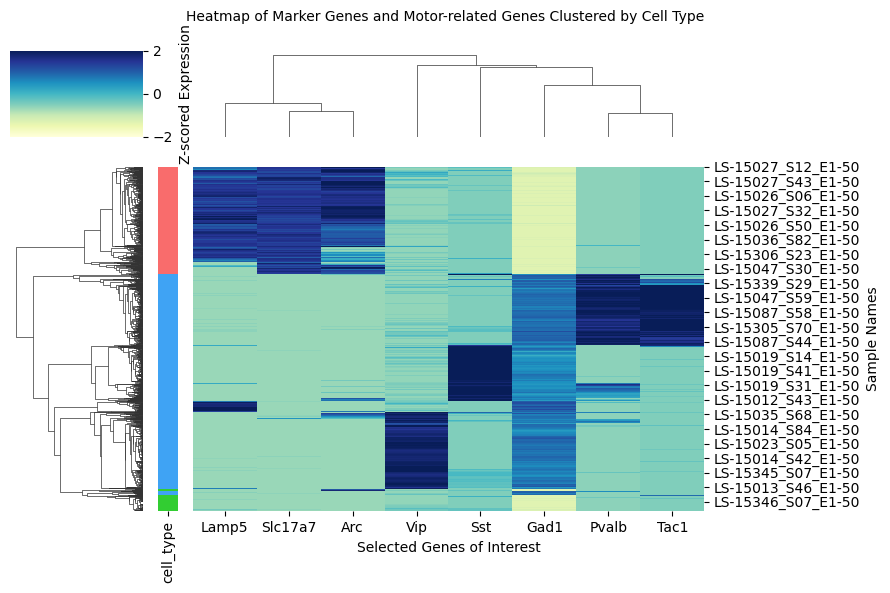

In [13]:
# Step 1.1: Extracting expression data for a few marker genes commonly observed in GABAergic or glutamatergic neurons, or genes believed to be involved in motor function
key_genes = ['Gad1', 'Slc17a7', 'Lamp5', 'Vip', 'Sst', 'Pvalb', 'Tac1', 'Arc']
subset_of_interest = merged_data[key_genes]

# Step 1.2: Extracting the cell type labels from the merged_data
cell_types = merged_data['cell_type']

# Step 1.3: Assigning a HEX color code to each cell type for visualization
palette = {"GABAergic": "#3fa3f4", "Glutamatergic": "#f96c6c", "Non-neuronal": "#32CD32"}

# Step 1.4: Mapping each sample to their cell type so that they will be colored accordingly
row_colors = cell_types.map(palette)  

# Step 1.5: Creating a heatmap that will blindly perform hierachical clustering of samples based on the gene expression 
figure = sns.clustermap(subset_of_interest, 
                        cmap='YlGnBu', 
                        annot=False, 
                        cbar_kws={'label': 'Z-scored Expression'}, 
                        vmin=-2, vmax=2, 
                        figsize=(9, 6), 
                        row_colors=row_colors) # Adding our cell types labels to check consistency

figure.fig.suptitle("Heatmap of Marker Genes and Motor-related Genes Clustered by Cell Type", fontsize=10)
figure.ax_heatmap.set_xlabel('Selected Genes of Interest')  
figure.ax_heatmap.set_ylabel('Sample Names')
plt.tight_layout()
plt.show()


Figure 2. Z-score normalized gene expression heatmap for various marker genes (Lamp5, Slc17a7, Vip, Sst, Gad1, Pvalb) and motor-related genes (Arc, Tac1). These eight genes are represented on the x-axis of the heatmap, while the 1,301 cell samples are represented on the y-axis, both of which are automatically clustered by Seaborn by similarity; the samples are also color-coded by cell_type (blue, red, and green) to further confirm that the built-in clustering function correctly distinguishes distinct transcriptional patterns across GABAergic, glutamatergic, and non-neuronal cells respectively. From the color gradient, bright red entries suggest strong expression, whereas dark blue entries suggest low expression in a sample. Not all sample names are included on the y-axis for the sake of clarity and easy visibility.

From this heatmap, it appears that samples strongly expressing Slc17a7 (encoding VGLUT1, a glutamate transporter) are also strongly expressing Arc, implying that glutamatergic neurons are possibly involved in motor learning, planning, and/or execution given Arc's role in the primary and secondary motor cortexes. Similarly, the same can be said about Pvalb (encoding parvalbumin) and Tac1, suggesting another positive relationship related to motor function; although Pvalb can be expressed in both glutamatergic and GABAergic neurons, the presence of GAD1 (encoding glutamate decarboxylase 1, a component involved in GABA neurotransmitter synthesis) confirms that Pvalb-positive cells in this dataset are classified as inhibitory. For both potential connections, we will perform correlation analyses in the following section to determine if their simultaneous expression does reflect a biologically-relevant functional relationship.

# Data Analysis and Results